## Imports

In [ ]:
!pip install patchify

In [ ]:
!pip install pandas seaborn plotly scikit-learn ipywidgets

In [1]:
import os
import random
import time
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import torch
import torchvision
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [2]:
torch.cuda.device_count() 

1

In [3]:
!echo $CUDA_VISIBLE_DEVICES

In [4]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
    
fix_all_seeds(2023)

## Configuration

In [5]:
TEST = False

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 2
NUM_EPOCHS = 20

TRAIN_PATH = '/media/jupyter-volume/livecell/images/livecell_train_val_images'
TEST_PATH = '/media/jupyter-volume/livecell/images/livecell_test_images'

WIDTH = 704
HEIGHT = 520

resize_factor = False
# resize_factor = 0.5

# Normalize to resnet mean and std if True.
NORMALIZE = True
RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

# optimizer params
MOMENTUM = 0.9
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005

# Changes the confidence required for a pixel to be kept for a mask.
# cell type specific thresholds
cell_type_dict = {'A172': 1, 'BT474': 2, 'BV2': 3, 'Huh7': 4, 'MCF7': 5, 'SHSY5Y': 6, 'SKOV3': 7, 'SkBr3': 8}
mask_threshold_dict = {1: 0.6, 2: 0.6, 3:  0.65, 4: 0.65, 5: 0.6, 6: 0.55, 7: 0.65, 8: 0.7}
min_score_dict = {1: 0.6, 2: 0.6, 3:  0.65, 4: 0.65, 5: 0.6, 6: 0.55, 7: 0.65, 8: 0.7}

# Use a StepLR scheduler if True.
# CosineAnnealingWarmRestarts: USE_SCHEDULER = False
USE_SCHEDULER = False

# Train / Validation split
PCT_IMAGES_VALIDATION = 0.15

# Maximum number of detections per image, for all classes
# Based on ~(mean + std) of instances in one image
BOX_DETECTIONS_PER_IMG = 540

In [6]:
DEVICE

device(type='cuda')

## Utilities

In [7]:
def rle_decode(mask_rle, shape, color=1):
    """
    Run Length Encoding Decode (get "image"-mask of an instance).

    :param mask_rle: run-length as string formated (start length)
    :param shape: (height, width, channels) of array to return
    :param color: color for the mask

    :return: Returns numpy array (mask)
    """
    s = mask_rle.split()

    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    if len(shape)==3:
        img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    else:
        img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for start, end in zip(starts, ends):
        img[start : end] = color

    return img.reshape(shape)


def rle_encoding(x):
    """
    Run Length Encoding (compress mask to save memory)

    :param x: mask

    :return: RLE of a mask
    """
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))


def remove_overlapping_pixels(mask, other_masks):
    """
    Remove overlapping pixels

    :param mask:
    :param other_masks:

    :return:
    """
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

def combine_masks(masks, mask_threshold):
    """
    Combine masks in one image

    :param masks:
    :param mask_threshold:

    :return:
    """
    if resize_factor:
        maskimg = np.zeros((int(HEIGHT*resize_factor), int(WIDTH*resize_factor)))
    else:
        maskimg = np.zeros((HEIGHT, WIDTH))

    for m, mask in enumerate(masks,1):
        maskimg[mask>mask_threshold] = m
    return maskimg


def get_filtered_masks(pred):
    """
    Filter masks using min_score_dict for masks and mask_threshold_dict for pixels

    :param pred: tensor output of a model

    :return:
    """
    use_masks = []   
    for i, mask in enumerate(pred["masks"]):
        scr = pred["scores"][i].cpu().item()
        label = pred["labels"][i].cpu().item()
        # masks
        if scr > min_score_dict[label]:
            mask = mask.cpu().numpy().squeeze()
            # pixels
            binary_mask = mask > mask_threshold_dict[label]
            binary_mask = remove_overlapping_pixels(binary_mask, use_masks)
            use_masks.append(binary_mask)

    return use_masks

### Metric: mean of the precision values at each IoU threshold

Ref: https://www.kaggle.com/theoviel/competition-metric-map-iou

In [8]:
def compute_iou(labels, y_pred, verbose=0):
    """
    Computes the IoU for instance labels and predictions.

    :param labels: Labels
    :param y_pred: predictions

    :return: np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    if verbose:
        print("Number of true objects: {}".format(true_objects))
        print("Number of predicted objects: {}".format(pred_objects))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    intersection = intersection[1:, 1:] # exclude background
    union = union[1:, 1:]
    union[union == 0] = 1e-9
    iou = intersection / union
    
    return iou  

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    :param threshold: Threshold
    :param iou: IoU matrix

    :return:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    :param truths: Ground truths
    :param preds: Predictions
    :param verbose: Whether to print infos. Defaults to 0.

    :return: mAP
    """
    ious = [compute_iou(truth, pred, verbose) for truth, pred in zip(truths, preds)]

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)


def get_score(ds, mdl):
    """
    Get average IoU mAP score for whole dataset
    """
    mdl.eval()
    iouscore = 0
    for i in tqdm(range(len(ds))):
        img, targets = ds[i]
        with torch.no_grad():
            result = mdl([img.to(DEVICE)])[0]
            
        masks = combine_masks(targets['masks'], 0.5)
        labels = pd.Series(result['labels'].cpu().numpy()).value_counts()

        mask_threshold = mask_threshold_dict[labels.sort_values().index[-1]]
        pred_masks = combine_masks(get_filtered_masks(result), mask_threshold)
        iouscore += iou_map([masks],[pred_masks])
    return iouscore / len(ds)


### Transformations

In [9]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class VerticalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-2)
        return image, target

class HorizontalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-1)
        return image, target

class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target
    

def get_transform(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())
    
    # Data augmentation for train
    if train: 
        transforms.append(HorizontalFlip(0.5))
        transforms.append(VerticalFlip(0.5))

    return Compose(transforms)

## Training Dataset and DataLoader

In [10]:
df = pd.read_csv('livecell_base_preprocessing_rle.csv')

In [11]:
df_base = df[df['original_split']!='test']
df_test = df[df['original_split']=='test']

### Before cutoff

In [12]:
df_images = df_base.groupby(["image_id", "cell_type"]).agg({'annotation': 'count'}).sort_values("annotation", ascending=False).reset_index()


In [13]:
df_images = df_base.groupby(["image_id", "cell_type"]).agg({'annotation': 'count'}).sort_values("annotation", ascending=False).reset_index()

for ct in cell_type_dict:
    ctdf = df_images[df_images["cell_type"]==ct].copy()
    if len(ctdf)>0:
        ctdf['quantiles'] = pd.qcut(ctdf['annotation'], 5)
        display(ctdf.head())

,image_id,cell_type,annotation,quantiles
425,182160,A172,656,"(329.0, 656.0]"
453,198359,A172,624,"(329.0, 656.0]"
469,209726,A172,617,"(329.0, 656.0]"
494,197510,A172,604,"(329.0, 656.0]"
501,193796,A172,593,"(329.0, 656.0]"


,image_id,cell_type,annotation,quantiles
595,8282,BT474,540,"(243.0, 540.0]"
715,12036,BT474,483,"(243.0, 540.0]"
753,30592,BT474,470,"(243.0, 540.0]"
764,6149,BT474,467,"(243.0, 540.0]"
765,36932,BT474,466,"(243.0, 540.0]"


,image_id,cell_type,annotation,quantiles
0,854664,BV2,3015,"(1135.0, 3015.0]"
1,878130,BV2,2904,"(1135.0, 3015.0]"
2,761918,BV2,2714,"(1135.0, 3015.0]"
3,692385,BV2,2588,"(1135.0, 3015.0]"
4,630312,BV2,2366,"(1135.0, 3015.0]"


,image_id,cell_type,annotation,quantiles
2044,1031838,Huh7,190,"(73.0, 190.0]"
2623,1013792,Huh7,132,"(73.0, 190.0]"
2627,1033144,Huh7,132,"(73.0, 190.0]"
2768,1022495,Huh7,120,"(73.0, 190.0]"
2828,1034131,Huh7,115,"(73.0, 190.0]"


,image_id,cell_type,annotation,quantiles
40,431135,MCF7,1522,"(753.0, 1522.0]"
42,469312,MCF7,1512,"(753.0, 1522.0]"
43,434977,MCF7,1505,"(753.0, 1522.0]"
47,291286,MCF7,1475,"(753.0, 1522.0]"
55,350801,MCF7,1424,"(753.0, 1522.0]"


,image_id,cell_type,annotation,quantiles
57,1421877,SHSY5Y,1418,"(574.0, 1418.0]"
66,1459176,SHSY5Y,1376,"(574.0, 1418.0]"
96,1571524,SHSY5Y,1234,"(574.0, 1418.0]"
106,1453362,SHSY5Y,1179,"(574.0, 1418.0]"
120,1542414,SHSY5Y,1140,"(574.0, 1418.0]"


,image_id,cell_type,annotation,quantiles
663,1344060,SKOV3,507,"(208.2, 507.0]"
710,1346440,SKOV3,486,"(208.2, 507.0]"
847,1340531,SKOV3,442,"(208.2, 507.0]"
861,1332838,SKOV3,436,"(208.2, 507.0]"
952,1351341,SKOV3,403,"(208.2, 507.0]"


,image_id,cell_type,annotation,quantiles
147,1172410,SkBr3,1043,"(498.6, 1043.0]"
164,1132455,SkBr3,993,"(498.6, 1043.0]"
165,1139358,SkBr3,991,"(498.6, 1043.0]"
185,1215066,SkBr3,968,"(498.6, 1043.0]"
257,1151391,SkBr3,838,"(498.6, 1043.0]"


In [14]:
df_images['annotation'].describe()

count    3823.000000
mean      313.938268
std       319.367439
min         1.000000
25%       112.000000
50%       205.000000
75%       402.000000
max      3015.000000
Name: annotation, dtype: float64

In [15]:
df_images.count()

image_id      3823
cell_type     3823
annotation    3823
dtype: int64

In [16]:
# trim everything with more than 640 segmentations
df_images = df_images[df_images['annotation'] <= 640]

### After cutoff

In [17]:
for ct in cell_type_dict:
    ctdf = df_images[df_images["cell_type"]==ct].copy()
    if len(ctdf)>0:
        ctdf['quantiles'] = pd.qcut(ctdf['annotation'], 5)
        display(ctdf.head())

,image_id,cell_type,annotation,quantiles
453,198359,A172,624,"(329.0, 624.0]"
469,209726,A172,617,"(329.0, 624.0]"
494,197510,A172,604,"(329.0, 624.0]"
501,193796,A172,593,"(329.0, 624.0]"
508,234112,A172,591,"(329.0, 624.0]"


,image_id,cell_type,annotation,quantiles
595,8282,BT474,540,"(243.0, 540.0]"
715,12036,BT474,483,"(243.0, 540.0]"
753,30592,BT474,470,"(243.0, 540.0]"
764,6149,BT474,467,"(243.0, 540.0]"
765,36932,BT474,466,"(243.0, 540.0]"


,image_id,cell_type,annotation,quantiles
460,906398,BV2,620,"(381.0, 620.0]"
470,670660,BV2,616,"(381.0, 620.0]"
474,782445,BV2,614,"(381.0, 620.0]"
479,765104,BV2,612,"(381.0, 620.0]"
483,892088,BV2,611,"(381.0, 620.0]"


,image_id,cell_type,annotation,quantiles
2044,1031838,Huh7,190,"(73.0, 190.0]"
2623,1013792,Huh7,132,"(73.0, 190.0]"
2627,1033144,Huh7,132,"(73.0, 190.0]"
2768,1022495,Huh7,120,"(73.0, 190.0]"
2828,1034131,Huh7,115,"(73.0, 190.0]"


,image_id,cell_type,annotation,quantiles
442,472154,MCF7,640,"(446.8, 640.0]"
443,383089,MCF7,639,"(446.8, 640.0]"
445,348824,MCF7,637,"(446.8, 640.0]"
459,472806,MCF7,621,"(446.8, 640.0]"
461,321125,MCF7,620,"(446.8, 640.0]"


,image_id,cell_type,annotation,quantiles
444,1537548,SHSY5Y,637,"(446.0, 637.0]"
446,1522022,SHSY5Y,635,"(446.0, 637.0]"
449,1575692,SHSY5Y,632,"(446.0, 637.0]"
452,1604443,SHSY5Y,625,"(446.0, 637.0]"
454,1552580,SHSY5Y,624,"(446.0, 637.0]"


,image_id,cell_type,annotation,quantiles
663,1344060,SKOV3,507,"(208.2, 507.0]"
710,1346440,SKOV3,486,"(208.2, 507.0]"
847,1340531,SKOV3,442,"(208.2, 507.0]"
861,1332838,SKOV3,436,"(208.2, 507.0]"
952,1351341,SKOV3,403,"(208.2, 507.0]"


,image_id,cell_type,annotation,quantiles
447,1128341,SkBr3,633,"(472.8, 633.0]"
448,1251289,SkBr3,632,"(472.8, 633.0]"
450,1123030,SkBr3,628,"(472.8, 633.0]"
451,1067062,SkBr3,628,"(472.8, 633.0]"
455,1249270,SkBr3,624,"(472.8, 633.0]"


In [18]:
df_images['annotation'].describe()

count    3381.000000
mean      221.811594
std       151.307028
min         1.000000
25%       101.000000
50%       181.000000
75%       313.000000
max       640.000000
Name: annotation, dtype: float64

# Data Loader

In [19]:
cell_type_dict = {'A172': 1, 'BT474': 2, 'BV2': 3, 'Huh7': 4, 'MCF7': 5, 'SHSY5Y': 6, 'SKOV3': 7, 'SkBr3': 8}

class LIVECellDataset(Dataset):
    def __init__(self, image_dir, df, transforms=None, resize=False):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = df
        
        self.should_resize = resize is not False
        if self.should_resize:
            self.height = int(HEIGHT * resize)
            self.width = int(WIDTH * resize)
        else:
            self.height = HEIGHT
            self.width = WIDTH
        
        self.image_info = collections.defaultdict(dict)
        temp_df = self.df.groupby(["image_id", "cell_type"])['annotation', 'bbox'].agg(lambda x: list(x)).reset_index()

        for index, row in temp_df.iterrows():
            file_name = self.df[df['image_id'] == row['image_id']]['file_name'].iloc[0]
            
            if self.df[df['image_id'] == row['image_id']]['original_split'].iloc[0] in ['train', 'val']:
                path_to_file = os.path.join(TRAIN_PATH, file_name)
            else:
                path_to_file = os.path.join(TEST_PATH, file_name)
            
            self.image_info[index] = {
                    'image_id': row['image_id'],
                    'image_path': path_to_file,
                    'annotations': list(row["annotation"]),
                    'bboxes': list(row['bbox']),
                    'cell_type': cell_type_dict[row["cell_type"]]
                    }
            
    def get_box(self, bbox_str):
        """
        Get the bounding box from string from df
        """
        bbox = np.fromstring(bbox_str[1:-1], sep=' ')
        x_min = bbox[0]
        y_min = bbox[1]
        w = bbox[2]
        h = bbox[3]
        x_max = x_min + w
        y_max = y_min + h
        
        if self.should_resize:
            x_min *= resize_factor
            y_min *= resize_factor
            x_max *= resize_factor
            y_max *= resize_factor
            
        return [x_min, y_min, x_max, y_max]

    def __getitem__(self, idx):
        """
        Get the image and the target
        """
        
        img_path = self.image_info[idx]["image_path"]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        
        if self.should_resize:
            img = cv2.resize(img, (self.width, self.height))

        info = self.image_info[idx]

        n_objects = len(info['annotations'])
        masks = np.zeros((len(info['annotations']), self.height, self.width), dtype=np.uint8)
        boxes = []
        labels = []

        for i, (annotation, bbox) in enumerate(zip(info['annotations'], info['bboxes'])):
            a_mask = rle_decode(annotation, (HEIGHT, WIDTH))

            if self.should_resize:
                a_mask = cv2.resize(a_mask, (self.width, self.height))
            
            a_mask = np.array(a_mask) > 0
            masks[i, :, :] = a_mask

            boxes.append(self.get_box(bbox))

        # labels
        labels = [int(info["cell_type"]) for _ in range(n_objects)]
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)

        # Required target for the Mask R-CNN
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.image_info)

In [21]:
df_images.groupby("cell_type").annotation.describe().astype(int)

,count,mean,std,min,25%,50%,75%,max
cell_type,,,,,,,,
A172,455,215,140,1,95,171,306,624
BT474,504,193,74,1,138,177,228,540
BV2,278,237,153,4,113,169,330,620
Huh7,456,57,20,21,43,56,68,190
MCF7,394,274,158,57,141,224,398,640
SHSY5Y,448,284,157,1,150,239,413,637
SKOV3,344,136,94,21,65,105,183,507
SkBr3,502,357,121,1,255,341,452,633


<AxesSubplot:>

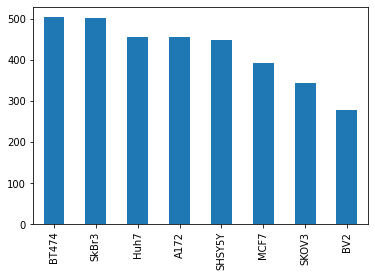

In [22]:
df_images.cell_type.value_counts().plot.bar()

In [23]:
df_images['cell_type'].value_counts()

BT474     504
SkBr3     502
Huh7      456
A172      455
SHSY5Y    448
MCF7      394
SKOV3     344
BV2       278
Name: cell_type, dtype: int64

In [27]:
df_images[['annotation']].describe().astype(int)

,annotation
count,3381
mean,221
std,151
min,1
25%,101
50%,181
75%,313
max,640


In [28]:
df_images_train, df_images_val = train_test_split(df_images, stratify=df_images['cell_type'],
                                                  test_size=PCT_IMAGES_VALIDATION,
                                                  random_state=1234)
df_train = df_base[df_base['image_id'].isin(df_images_train['image_id'])]
df_val = df_base[df_base['image_id'].isin(df_images_val['image_id'])]
print(f"Images in train set:           {len(df_images_train)}")
print(f"Annotations in train set:      {len(df_train)}")
print(f"Images in validation set:      {len(df_images_val)}")
print(f"Annotations in validation set: {len(df_val)}")

Images in train set:           2873
Annotations in train set:      640962
Images in validation set:      508
Annotations in validation set: 108983


In [30]:
ds_train = LIVECellDataset(TRAIN_PATH, df_train, resize=resize_factor, transforms=get_transform(train=False))
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,
                      num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

ds_val = LIVECellDataset(TRAIN_PATH, df_val, resize=resize_factor, transforms=get_transform(train=False))
dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=True, pin_memory=False,
                    num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [29]:
len(df_train)

640962

In [31]:
img, targets = ds_train[10]

In [32]:
def visualise_gt_pred(img, targets) -> None:
    """
    Print original image and ground truth with segmentation masks;
    """

    l = np.unique(targets["labels"])
    ig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,60), facecolor="#fefefe")
    ax[0].imshow(img.numpy().transpose((1,2,0)))
    ax[0].set_title(f"cell type {l}")
    ax[0].axis("off")
    
    masks = combine_masks(targets['masks'], 0.5)
    ax[1].imshow(masks)
    ax[1].set_title(f"Ground truth, {len(targets['masks'])} cells")
    ax[1].axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


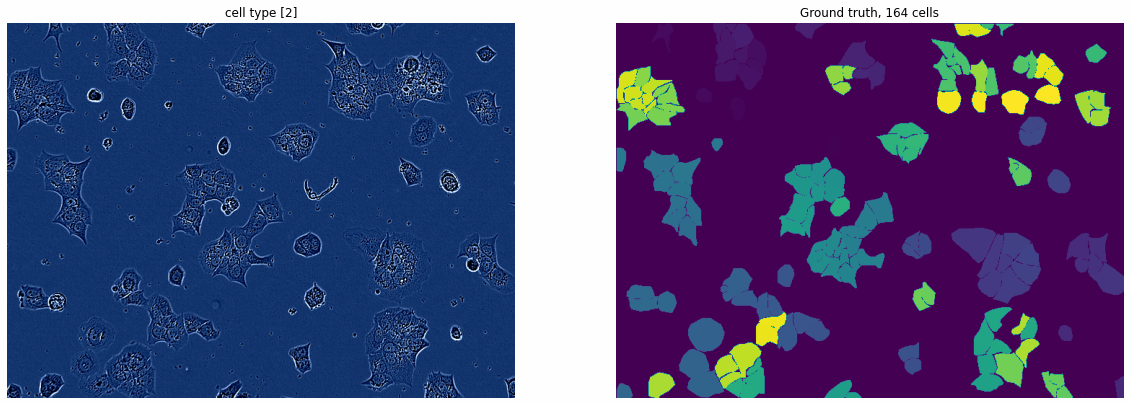

In [33]:
visualise_gt_pred(img, targets)

In [34]:
img.shape

torch.Size([3, 520, 704])

In [36]:
targets['masks'].shape

torch.Size([164, 520, 704])

# Train model

## Setup

In [ ]:
# Override pythorch checkpoint with an "offline" version of the file
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp ../input/cocopre/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth

In [37]:
from torchvision.models.detection.rpn import AnchorGenerator

anchor_sizes = ((4,), (8,), (16,), (32,), (64,))
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)

def get_model(num_classes, model_chkpt=None):
    anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
    
    if NORMALIZE:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                   box_detections_per_img=BOX_DETECTIONS_PER_IMG,
                                                                   rpn_anchor_generator=anchor_generator,
                                                                   image_mean=RESNET_MEAN,
                                                                   image_std=RESNET_STD)
    else:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                   box_detections_per_img=BOX_DETECTIONS_PER_IMG,
                                                                   rpn_anchor_generator=anchor_generator)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes+1)
    
    if model_chkpt:
        model.load_state_dict(torch.load(model_chkpt, map_location=DEVICE))

    return model

# Get the Mask R-CNN model
# The model does classification, bounding boxes and MASKs for individuals, all at the same time
# We only care about MASKS
# model = torch.nn.parallel.DistributedDataParallel(get_model(len(cell_type_dict)), device_ids=[0, 1])
model = get_model(len(cell_type_dict))
model.to(DEVICE)

for param in model.parameters():
    param.requires_grad = True
    
model.train();

## Training loop!

In [37]:
!pip install wandb 

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.


In [38]:
# Wandb Login
import wandb
wandb.login()

/usr/lib/python3/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eugeneshally. Use `wandb login --relogin` to force relogin


True

In [39]:
# Initialize W&B
wandb.init(project="livecell", entity="eugeneshally")


In [40]:
wandb.config = {
  "learning_rate": LEARNING_RATE,
  "epochs": NUM_EPOCHS,
  "batch_size": BATCH_SIZE
}

In [41]:
from torch.optim.swa_utils import SWALR

swa_model = torch.optim.swa_utils.AveragedModel(model)

In [42]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#optimizer = torch.optim.Adam(params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=2, T_mult=2, eta_min=0.0002)
swa_scheduler = SWALR(optimizer, anneal_strategy="cos", anneal_epochs=1, swa_lr=0.02)

# Use MAP
use_amp = True
if use_amp:
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

n_batches, n_batches_val = len(dl_train), len(dl_val)

validation_mask_losses = []

steps = len(df_train) // 5000
steps = 1
step = 0

# Automatically log Gradients
wandb.watch(model, log_freq=100, log="all")
optimizer.zero_grad()
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Starting epoch {epoch} of {NUM_EPOCHS}")

    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0
    loss_classifier_accum = 0.0
    optimizer.zero_grad()
    
    for batch_idx, (images, targets) in tqdm(enumerate(dl_train, 1)):
        # with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
        if use_amp:
            with torch.cuda.amp.autocast():
                images = list(image.to(DEVICE, non_blocking=True) for image in images)
                targets = [{k: v.to(DEVICE, non_blocking=True) for k, v in t.items()} for t in targets]

                loss_dict = model(images, targets)
                loss = sum(loss for loss in loss_dict.values())
            
#             optimizer.zero_grad()

            # Backward pass without mixed precision
            # It's not recommended to use mixed precision for backward pass
            # Because we need more precise loss
            scaler.scale(loss).backward()
            
            # Only update weights every other 4 iterations
            # Effective batch size is doubled
            # if (batch_idx+1) % 4 == 0 or (batch_idx+1) == n_batches:
                # scaler.step() first unscales the gradients .
                # If these gradients contain infs or NaNs, 
                # optimizer.step() is skipped.
            scaler.step(optimizer) 
                # If optimizer.step() was skipped,
                # scaling factor is reduced by the backoff_factor in GradScaler()
            scaler.update()
                # Zero Gradients
            optimizer.zero_grad()
                
            
        else:
            
            
            images = list(image.to(DEVICE, non_blocking=True) for image in images)
            targets = [{k: v.to(DEVICE, non_blocking=True) for k, v in t.items()} for t in targets]
        
            loss_dict = model(images, targets)

            del images
            del targets
        
            loss = sum(loss for loss in loss_dict.values())
            
            loss.backward()
            
            # Only update weights every other 4 iterations
            # Effective batch size is doubled
            # if (batch_idx+1) % 4 == 0 or (batch_idx+1) == n_batches:
                # Update weights
            optimizer.step()
                # Zero Gradients
            optimizer.zero_grad()
                
            # Backprop
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
        
        lr_scheduler.step(epoch + batch_idx / n_batches)
        
        # Logging
        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += float(loss.item())
        loss_mask_accum += float(loss_mask)
        loss_classifier_accum += float(loss_dict['loss_classifier'].item())  
        
        if batch_idx % 500 == 0:
            print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}. Mask-only loss: {loss_mask:7.3f}.")
        
    if USE_SCHEDULER:
        lr_scheduler.step()
    
    swa_model.update_parameters(model)
    swa_scheduler.step()
    
    # Train losses
    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches
    train_loss_classifier = loss_classifier_accum / n_batches

    # Validation
    val_loss_accum = 0
    val_loss_mask_accum = 0
    val_loss_classifier_accum = 0
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(dl_val, 1):
            images = list(image.to(DEVICE, non_blocking=True) for image in images)
            targets = [{k: v.to(DEVICE, non_blocking=True) for k, v in t.items()} for t in targets]

            val_loss_dict = model(images, targets)
            val_batch_loss = sum(loss for loss in val_loss_dict.values())
            val_loss_accum += val_batch_loss.item()
            val_loss_mask_accum += val_loss_dict['loss_mask'].item()
            val_loss_classifier_accum += val_loss_dict['loss_classifier'].item()

    # Validation losses
    val_loss = val_loss_accum / n_batches_val
    val_loss_mask = val_loss_mask_accum / n_batches_val
    val_loss_classifier = val_loss_classifier_accum / n_batches_val
    elapsed = time.time() - time_start
    
    validation_mask_losses.append(val_loss_mask)
    
    # Log the metrics
    wandb.log({"Train Loss": train_loss})
    wandb.log({"Train Loss Mask": train_loss_mask})
    wandb.log({"Train Loss Classification": train_loss_classifier})
    wandb.log({"Valid Loss": val_loss})
    wandb.log({"Valid Loss Mask": val_loss_mask})
    wandb.log({"Valid Loss Classification": val_loss_classifier})
    
#     wandb.log({"Valid Loss": val_epoch_loss})
#     wandb.log({"Valid RMSE": val_epoch_rmse})

    torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")
#     path_save_model =  
#     wandb.save(path_save_model)
    prefix = f"[Epoch {epoch:2d} / {NUM_EPOCHS:2d}]"
    print(prefix)
    print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}, classifier loss {train_loss_classifier:7.3f}")
    print(f"{prefix} Val mask-only loss  : {val_loss_mask:7.3f}, classifier loss {val_loss_classifier:7.3f}")
    print(prefix)
    print(f"{prefix} Train loss: {train_loss:7.3f}. Val loss: {val_loss:7.3f} [{elapsed:.0f} secs]")
    print(prefix)

Starting epoch 1 of 20


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


    [Batch 500 / 1437] Batch train loss:   1.648. Mask-only loss:   0.397.
    [Batch 1000 / 1437] Batch train loss:   1.434. Mask-only loss:   0.307.
[Epoch  1 / 20]
[Epoch  1 / 20] Train mask-only loss:   0.369, classifier loss   0.471
[Epoch  1 / 20] Val mask-only loss  :   0.310, classifier loss   0.339
[Epoch  1 / 20]
[Epoch  1 / 20] Train loss:   1.568. Val loss:   1.379 [345 secs]
[Epoch  1 / 20]
Starting epoch 2 of 20


0it [00:00, ?it/s]

    [Batch 500 / 1437] Batch train loss:   1.055. Mask-only loss:   0.256.
    [Batch 1000 / 1437] Batch train loss:   1.258. Mask-only loss:   0.317.
[Epoch  2 / 20]
[Epoch  2 / 20] Train mask-only loss:   0.295, classifier loss   0.383
[Epoch  2 / 20] Val mask-only loss  :   0.279, classifier loss   0.295
[Epoch  2 / 20]
[Epoch  2 / 20] Train loss:   1.357. Val loss:   1.219 [344 secs]
[Epoch  2 / 20]
Starting epoch 3 of 20


0it [00:00, ?it/s]

    [Batch 500 / 1437] Batch train loss:   1.070. Mask-only loss:   0.262.
    [Batch 1000 / 1437] Batch train loss:   1.166. Mask-only loss:   0.287.
[Epoch  3 / 20]
[Epoch  3 / 20] Train mask-only loss:   0.276, classifier loss   0.284
[Epoch  3 / 20] Val mask-only loss  :   0.271, classifier loss   0.251
[Epoch  3 / 20]
[Epoch  3 / 20] Train loss:   1.180. Val loss:   1.145 [342 secs]
[Epoch  3 / 20]
Starting epoch 4 of 20


0it [00:00, ?it/s]

    [Batch 500 / 1437] Batch train loss:   0.978. Mask-only loss:   0.245.
    [Batch 1000 / 1437] Batch train loss:   0.894. Mask-only loss:   0.261.
[Epoch  4 / 20]
[Epoch  4 / 20] Train mask-only loss:   0.269, classifier loss   0.241
[Epoch  4 / 20] Val mask-only loss  :   0.268, classifier loss   0.223
[Epoch  4 / 20]
[Epoch  4 / 20] Train loss:   1.095. Val loss:   1.070 [342 secs]
[Epoch  4 / 20]
Starting epoch 5 of 20


0it [00:00, ?it/s]

    [Batch 500 / 1437] Batch train loss:   0.886. Mask-only loss:   0.250.
    [Batch 1000 / 1437] Batch train loss:   1.229. Mask-only loss:   0.330.
[Epoch  5 / 20]
[Epoch  5 / 20] Train mask-only loss:   0.267, classifier loss   0.228
[Epoch  5 / 20] Val mask-only loss  :   0.268, classifier loss   0.221
[Epoch  5 / 20]
[Epoch  5 / 20] Train loss:   1.066. Val loss:   1.071 [342 secs]
[Epoch  5 / 20]
Starting epoch 6 of 20


0it [00:00, ?it/s]

    [Batch 500 / 1437] Batch train loss:   1.099. Mask-only loss:   0.259.
    [Batch 1000 / 1437] Batch train loss:   1.295. Mask-only loss:   0.303.
[Epoch  6 / 20]
[Epoch  6 / 20] Train mask-only loss:   0.268, classifier loss   0.261
[Epoch  6 / 20] Val mask-only loss  :   0.268, classifier loss   0.218
[Epoch  6 / 20]
[Epoch  6 / 20] Train loss:   1.109. Val loss:   1.059 [343 secs]
[Epoch  6 / 20]
Starting epoch 7 of 20


0it [00:00, ?it/s]

    [Batch 500 / 1437] Batch train loss:   1.027. Mask-only loss:   0.255.
    [Batch 1000 / 1437] Batch train loss:   0.970. Mask-only loss:   0.243.
[Epoch  7 / 20]
[Epoch  7 / 20] Train mask-only loss:   0.264, classifier loss   0.234
[Epoch  7 / 20] Val mask-only loss  :   0.261, classifier loss   0.221
[Epoch  7 / 20]
[Epoch  7 / 20] Train loss:   1.057. Val loss:   1.033 [343 secs]
[Epoch  7 / 20]
Starting epoch 8 of 20


0it [00:00, ?it/s]

    [Batch 500 / 1437] Batch train loss:   0.713. Mask-only loss:   0.186.
    [Batch 1000 / 1437] Batch train loss:   0.982. Mask-only loss:   0.247.
[Epoch  8 / 20]
[Epoch  8 / 20] Train mask-only loss:   0.261, classifier loss   0.218
[Epoch  8 / 20] Val mask-only loss  :   0.262, classifier loss   0.216
[Epoch  8 / 20]
[Epoch  8 / 20] Train loss:   1.022. Val loss:   1.033 [343 secs]
[Epoch  8 / 20]
Starting epoch 9 of 20


0it [00:00, ?it/s]

    [Batch 500 / 1437] Batch train loss:   1.133. Mask-only loss:   0.261.
    [Batch 1000 / 1437] Batch train loss:   0.938. Mask-only loss:   0.255.
[Epoch  9 / 20]
[Epoch  9 / 20] Train mask-only loss:   0.259, classifier loss   0.210
[Epoch  9 / 20] Val mask-only loss  :   0.260, classifier loss   0.214
[Epoch  9 / 20]
[Epoch  9 / 20] Train loss:   1.003. Val loss:   1.029 [342 secs]
[Epoch  9 / 20]
Starting epoch 10 of 20


0it [00:00, ?it/s]

    [Batch 500 / 1437] Batch train loss:   1.075. Mask-only loss:   0.283.
    [Batch 1000 / 1437] Batch train loss:   1.012. Mask-only loss:   0.249.
[Epoch 10 / 20]
[Epoch 10 / 20] Train mask-only loss:   0.259, classifier loss   0.208
[Epoch 10 / 20] Val mask-only loss  :   0.259, classifier loss   0.206
[Epoch 10 / 20]
[Epoch 10 / 20] Train loss:   0.992. Val loss:   1.008 [342 secs]
[Epoch 10 / 20]
Starting epoch 11 of 20


0it [00:00, ?it/s]

    [Batch 500 / 1437] Batch train loss:   0.886. Mask-only loss:   0.227.
    [Batch 1000 / 1437] Batch train loss:   1.018. Mask-only loss:   0.292.
[Epoch 11 / 20]
[Epoch 11 / 20] Train mask-only loss:   0.257, classifier loss   0.201
[Epoch 11 / 20] Val mask-only loss  :   0.259, classifier loss   0.203
[Epoch 11 / 20]
[Epoch 11 / 20] Train loss:   0.978. Val loss:   0.995 [344 secs]
[Epoch 11 / 20]
Starting epoch 12 of 20


0it [00:00, ?it/s]

    [Batch 500 / 1437] Batch train loss:   0.701. Mask-only loss:   0.210.
    [Batch 1000 / 1437] Batch train loss:   1.375. Mask-only loss:   0.335.
[Epoch 12 / 20]
[Epoch 12 / 20] Train mask-only loss:   0.256, classifier loss   0.197
[Epoch 12 / 20] Val mask-only loss  :   0.258, classifier loss   0.204
[Epoch 12 / 20]
[Epoch 12 / 20] Train loss:   0.966. Val loss:   0.995 [341 secs]
[Epoch 12 / 20]
Starting epoch 13 of 20


0it [00:00, ?it/s]

    [Batch 500 / 1437] Batch train loss:   0.936. Mask-only loss:   0.271.
    [Batch 1000 / 1437] Batch train loss:   1.082. Mask-only loss:   0.266.
[Epoch 13 / 20]
[Epoch 13 / 20] Train mask-only loss:   0.256, classifier loss   0.196
[Epoch 13 / 20] Val mask-only loss  :   0.258, classifier loss   0.202
[Epoch 13 / 20]
[Epoch 13 / 20] Train loss:   0.963. Val loss:   0.990 [342 secs]
[Epoch 13 / 20]
Starting epoch 14 of 20


0it [00:00, ?it/s]

    [Batch 500 / 1437] Batch train loss:   1.087. Mask-only loss:   0.293.
    [Batch 1000 / 1437] Batch train loss:   0.828. Mask-only loss:   0.219.
[Epoch 14 / 20]
[Epoch 14 / 20] Train mask-only loss:   0.257, classifier loss   0.218
[Epoch 14 / 20] Val mask-only loss  :   0.258, classifier loss   0.213
[Epoch 14 / 20]
[Epoch 14 / 20] Train loss:   0.998. Val loss:   1.009 [342 secs]
[Epoch 14 / 20]
Starting epoch 15 of 20


0it [00:00, ?it/s]

    [Batch 500 / 1437] Batch train loss:   1.150. Mask-only loss:   0.270.
    [Batch 1000 / 1437] Batch train loss:   0.858. Mask-only loss:   0.233.
[Epoch 15 / 20]
[Epoch 15 / 20] Train mask-only loss:   0.256, classifier loss   0.211
[Epoch 15 / 20] Val mask-only loss  :   0.259, classifier loss   0.212
[Epoch 15 / 20]
[Epoch 15 / 20] Train loss:   0.982. Val loss:   1.005 [343 secs]
[Epoch 15 / 20]
Starting epoch 16 of 20


0it [00:00, ?it/s]

    [Batch 500 / 1437] Batch train loss:   1.209. Mask-only loss:   0.299.
    [Batch 1000 / 1437] Batch train loss:   1.298. Mask-only loss:   0.305.
[Epoch 16 / 20]
[Epoch 16 / 20] Train mask-only loss:   0.255, classifier loss   0.210
[Epoch 16 / 20] Val mask-only loss  :   0.257, classifier loss   0.212
[Epoch 16 / 20]
[Epoch 16 / 20] Train loss:   0.976. Val loss:   0.992 [345 secs]
[Epoch 16 / 20]
Starting epoch 17 of 20


0it [00:00, ?it/s]

    [Batch 500 / 1437] Batch train loss:   0.916. Mask-only loss:   0.233.
    [Batch 1000 / 1437] Batch train loss:   0.536. Mask-only loss:   0.175.
[Epoch 17 / 20]
[Epoch 17 / 20] Train mask-only loss:   0.254, classifier loss   0.200
[Epoch 17 / 20] Val mask-only loss  :   0.256, classifier loss   0.200
[Epoch 17 / 20]
[Epoch 17 / 20] Train loss:   0.958. Val loss:   0.982 [341 secs]
[Epoch 17 / 20]
Starting epoch 18 of 20


0it [00:00, ?it/s]

    [Batch 500 / 1437] Batch train loss:   1.069. Mask-only loss:   0.291.
    [Batch 1000 / 1437] Batch train loss:   0.995. Mask-only loss:   0.249.
[Epoch 18 / 20]
[Epoch 18 / 20] Train mask-only loss:   0.252, classifier loss   0.195
[Epoch 18 / 20] Val mask-only loss  :   0.256, classifier loss   0.205
[Epoch 18 / 20]
[Epoch 18 / 20] Train loss:   0.944. Val loss:   0.977 [343 secs]
[Epoch 18 / 20]
Starting epoch 19 of 20


0it [00:00, ?it/s]

    [Batch 500 / 1437] Batch train loss:   0.615. Mask-only loss:   0.169.
    [Batch 1000 / 1437] Batch train loss:   0.598. Mask-only loss:   0.195.
[Epoch 19 / 20]
[Epoch 19 / 20] Train mask-only loss:   0.251, classifier loss   0.192
[Epoch 19 / 20] Val mask-only loss  :   0.254, classifier loss   0.196
[Epoch 19 / 20]
[Epoch 19 / 20] Train loss:   0.935. Val loss:   0.957 [343 secs]
[Epoch 19 / 20]
Starting epoch 20 of 20


0it [00:00, ?it/s]

    [Batch 500 / 1437] Batch train loss:   1.088. Mask-only loss:   0.291.
    [Batch 1000 / 1437] Batch train loss:   1.345. Mask-only loss:   0.328.
[Epoch 20 / 20]
[Epoch 20 / 20] Train mask-only loss:   0.251, classifier loss   0.189
[Epoch 20 / 20] Val mask-only loss  :   0.256, classifier loss   0.199
[Epoch 20 / 20]
[Epoch 20 / 20] Train loss:   0.927. Val loss:   0.972 [343 secs]
[Epoch 20 / 20]


In [43]:
torch.optim.swa_utils.update_bn(dl_train, swa_model)
torch.save(swa_model.module.state_dict(), 'swa_model.pth')

# Analyze prediction results for train set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


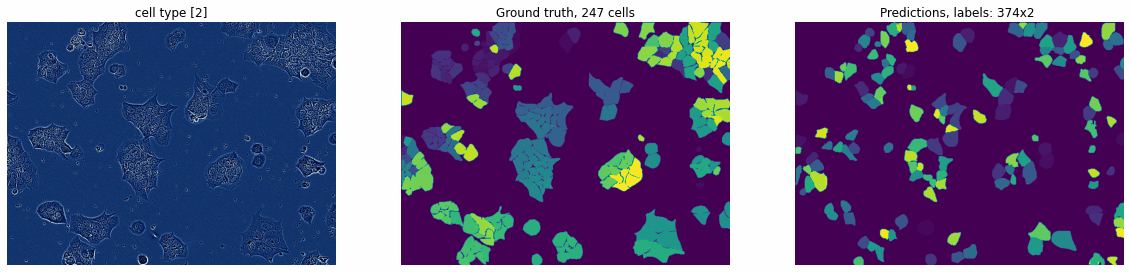

Score: 0.24855080758335846


In [44]:
# Plots: the image, The image + the ground truth mask, The image + the predicted mask

def analyze_train_sample(model, ds_train, sample_index):
    
    img, targets = ds_train[sample_index]
    #print(img.shape)
    l = np.unique(targets["labels"])
    ig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,60), facecolor="#fefefe")
    ax[0].imshow(img.numpy().transpose((1,2,0)))
    ax[0].set_title(f"cell type {l}")
    ax[0].axis("off")
    
    masks = combine_masks(targets['masks'], 0.5)
    #plt.imshow(img.numpy().transpose((1,2,0)))
    ax[1].imshow(masks)
    ax[1].set_title(f"Ground truth, {len(targets['masks'])} cells")
    ax[1].axis("off")
    
    model.eval()
    with torch.no_grad():
        preds = model([img.to(DEVICE)])[0]
    
    l = pd.Series(preds['labels'].cpu().numpy()).value_counts()
    lstr = ""
    for i in l.index:
        lstr += f"{l[i]}x{i} "
    #print(l, l.sort_values().index[-1])
    #plt.imshow(img.cpu().numpy().transpose((1,2,0)))
    mask_threshold = mask_threshold_dict[l.sort_values().index[-1]]
    #print(mask_threshold)
    pred_masks = combine_masks(get_filtered_masks(preds), mask_threshold)
    ax[2].imshow(pred_masks)
    ax[2].set_title(f"Predictions, labels: {lstr}")
    ax[2].axis("off")
    plt.show() 
    
    #print(masks.shape, pred_masks.shape)
    score = iou_map([masks],[pred_masks])
    print("Score:", score)    
    
    
analyze_train_sample(model, ds_train, 6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


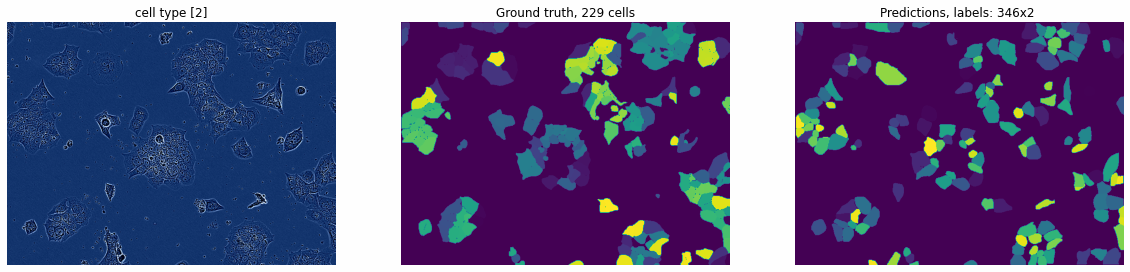

Score: 0.2627916844578462


In [45]:
analyze_train_sample(model, ds_train, 102)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


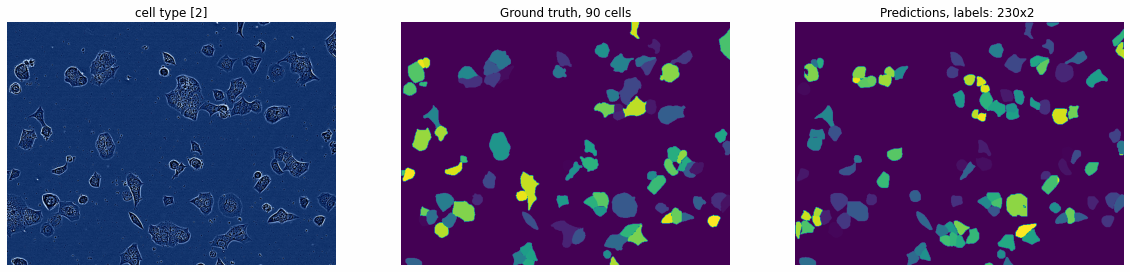

Score: 0.4279933372775912


In [46]:
analyze_train_sample(model, ds_train, 7)

## Get the model from the best epoch

In [40]:
# Epochs with their losses and IOU scores

val_scores = pd.DataFrame()
# for e, val_loss in enumerate(validation_mask_losses):
for i in range(10):
    model_chk = f"pytorch_model-e{i+1}.bin"
    print("Loading:", model_chk)
    model = get_model(len(cell_type_dict), model_chk)
    model.load_state_dict(torch.load(model_chk))
    model = model.to(DEVICE)
    # val_scores.loc[i,"mask_loss"] = val_loss
    val_scores.loc[i,"score"] = get_score(ds_val, model)
    
    
display(val_scores.sort_values("score", ascending=False))

best_epoch = np.argmax(val_scores["score"])
print(best_epoch+1)

Loading: pytorch_model-e1.bin


  0%|          | 0/508 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading: pytorch_model-e2.bin


  0%|          | 0/508 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [41]:
model_chk = f"pytorch_model-e12.bin"
print("Loading:", model_chk)
model = get_model(len(cell_type_dict), model_chk)
model.load_state_dict(torch.load(model_chk))
model = model.to(DEVICE)
print(get_score(ds_val, model))

Loading: pytorch_model-e12.bin


  0%|          | 0/508 [00:00<?, ?it/s]

0.3578909828675392


In [42]:
model_chk = f"swa_model.pth"
model = get_model(len(cell_type_dict), model_chk)
model.load_state_dict(torch.load(model_chk))
model = model.to(DEVICE)
# val_loss
print(get_score(ds_val, model))

  0%|          | 0/508 [00:00<?, ?it/s]

0.3333635834790293
